In [1]:
!pip install yfinance

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 대구은행 주식 데이터
ticker = "139130.KS"
df = yf.download(ticker, start="2015-01-01", end="2024-01-01")

df = df.reset_index()

X = df[['Open', 'High', 'Low', 'Volume']].values
y = df['Close'].values

[*********************100%***********************]  1 of 1 completed


<ipython-input-3-14ad7f65b736>:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view([-1, 1])


[epoch: 0] loss: 0.1838
[epoch: 100] loss: 0.0346


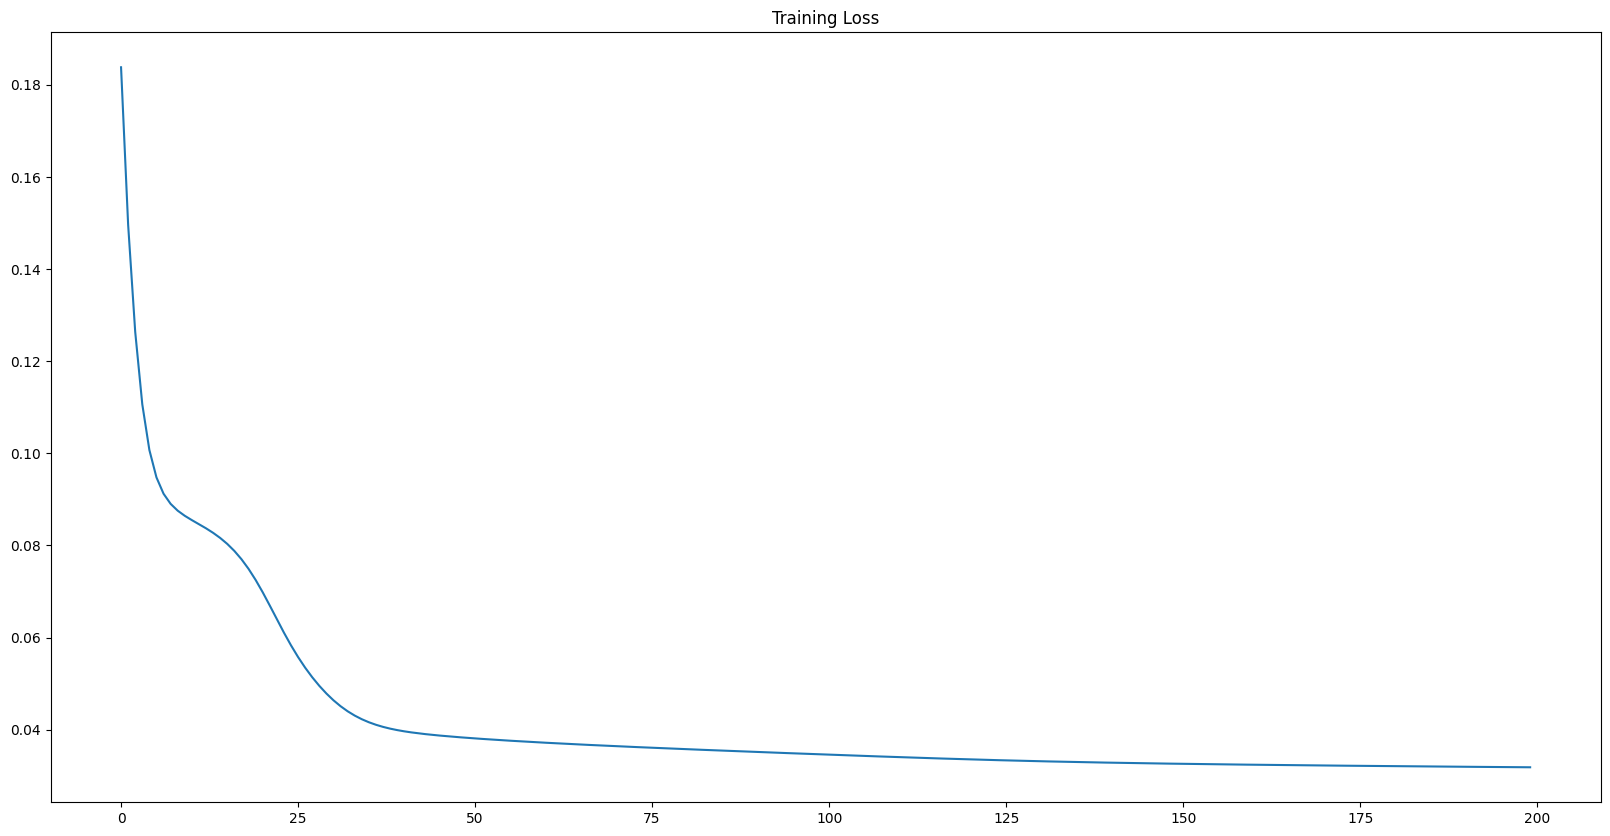

In [3]:
scaler_X = RobustScaler()
scaler_y = RobustScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# 시퀀스 데이터
def seq_data(x, y, sequence_length):
    x_seq = []
    y_seq = []
    for i in range(len(x) - sequence_length):
        x_seq.append(x[i: i+sequence_length])
        y_seq.append(y[i+sequence_length])
    return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view([-1, 1])

sequence_length = 5
split = 200

x_seq, y_seq = seq_data(X_scaled, y_scaled, sequence_length)

x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]
x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]

train = TensorDataset(x_train_seq, y_train_seq)
test = TensorDataset(x_test_seq, y_test_seq)

batch_size = 16
train_loader = DataLoader(dataset=train, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test, batch_size=batch_size, shuffle=False)

input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

class VanillaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
        super(VanillaRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size * sequence_length, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(device)
        out, _ = self.rnn(x, h0)
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)
        return out

model = VanillaRNN(input_size=input_size,
                   hidden_size=hidden_size,
                   sequence_length=sequence_length,
                   num_layers=num_layers,
                   device=device).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 200
loss_graph = []

for epoch in range(num_epochs):
    running_loss = 0.0
    for data in train_loader:
        seq, target = data
        out = model(seq)
        loss = criterion(out, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    loss_graph.append(running_loss / len(train_loader))
    if epoch % 100 == 0:
        print(f'[epoch: {epoch}] loss: {running_loss / len(train_loader):.4f}')

plt.figure(figsize=(20,10))
plt.plot(loss_graph)
plt.title('Training Loss')
plt.show()

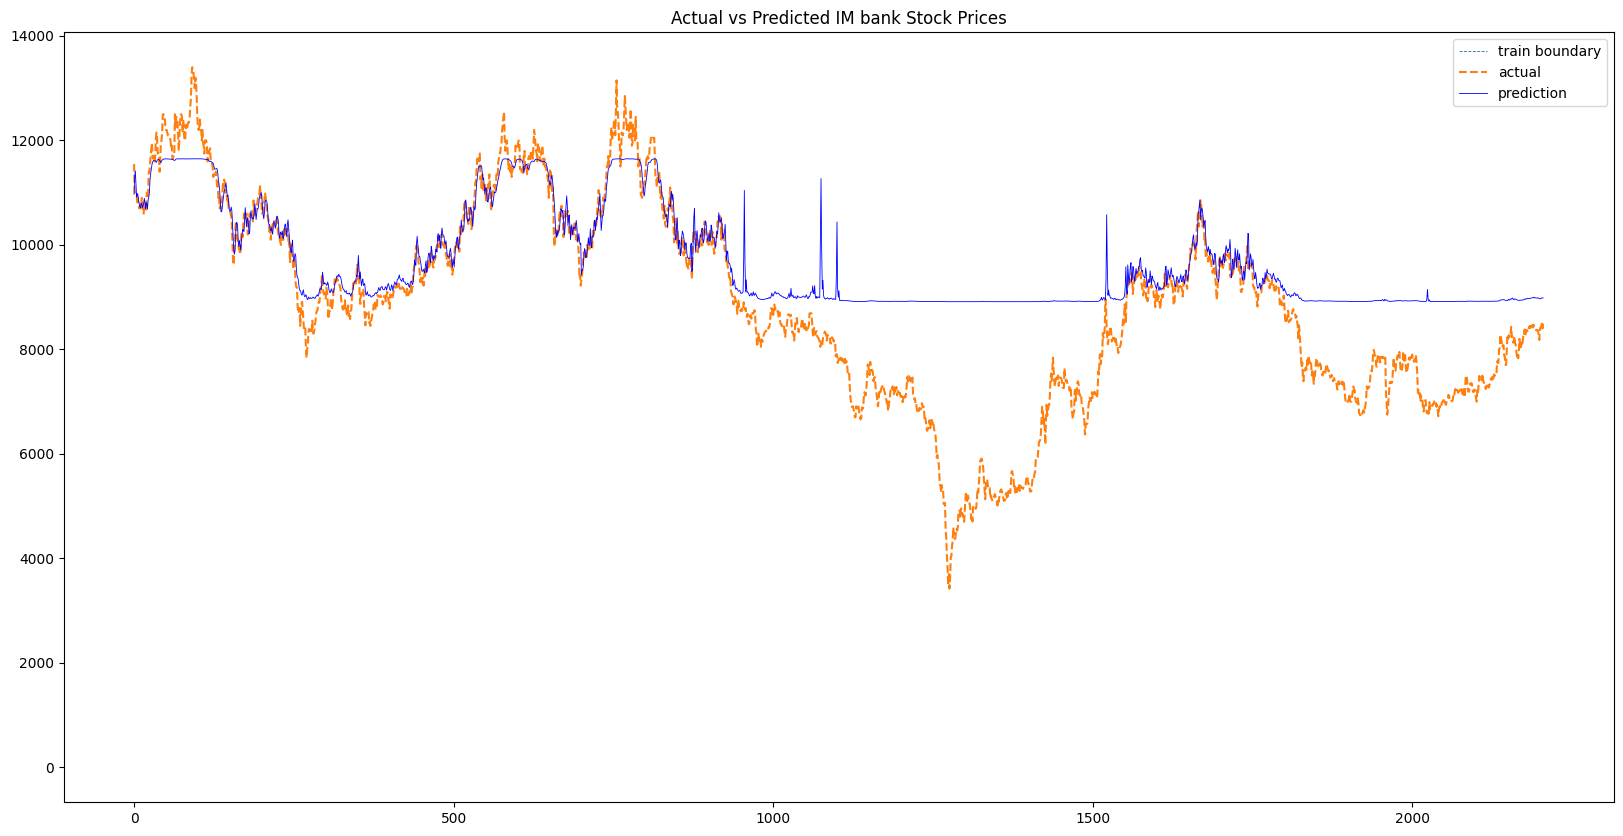

In [4]:
with torch.no_grad():
    train_pred = []
    test_pred = []

    for data in train_loader:
        seq, target = data
        out = model(seq)
        train_pred += out.cpu().numpy().tolist()

    for data in test_loader:
        seq, target = data
        out = model(seq)
        test_pred += out.cpu().numpy().tolist()

total = train_pred + test_pred
total_inverse = scaler_y.inverse_transform(total)

plt.figure(figsize=(20,10))
plt.plot(np.ones(100)*len(train_pred), np.linspace(0,1,100), '--', linewidth=0.6)
plt.plot(df['Close'][sequence_length:].values, '--')
plt.plot(total_inverse, 'b', linewidth=0.6)
plt.title('Actual vs Predicted IM bank Stock Prices')
plt.legend(['train boundary', 'actual', 'prediction'])
plt.show()